In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from FNN import FNN
from ActivFunctions import sigmoid
from gradient_descent import train_sgd
from LossFunctions import MeanSquaredError

# paths
TRAIN_CSV_PATH = "Mnist/fashion-mnist_train.csv"
TEST_CSV_PATH  = "Mnist/fashion-mnist_test.csv"

# Adjust later.... 
NUM_CLASSES   = 10
HIDDEN_UNITS  = 128
EPOCHS        = 5 # increase later
LEARNING_RATE = 0.01
RANDOM_SEED   = 42

# to make runs faster while developing
MAX_TRAIN_SAMPLES = 10000   # or None for all
MAX_TEST_SAMPLES  = 2000    # or None for all

np.random.seed(RANDOM_SEED)
%matplotlib inline


In [ ]:
# Load and preprocess Fashion-MNIST

def one_hot(labels, num_classes):
    labels = labels.astype(int)
    return np.eye(num_classes)[labels].T   # (num_classes, n_samples)


def load_fashion_mnist(train_path, test_path):
    train_data = np.loadtxt(train_path, delimiter=",", skiprows=1)
    test_data  = np.loadtxt(test_path,  delimiter=",", skiprows=1)

    y_train = train_data[:, 0]
    X_train = train_data[:, 1:]
    y_test  = test_data[:, 0]
    X_test  = test_data[:, 1:]

    # normalize to [0,1]
    X_train = (X_train / 255.0).astype(np.float64)
    X_test  = (X_test  / 255.0).astype(np.float64)

    return X_train, y_train, X_test, y_test


X_train_raw, y_train, X_test_raw, y_test = load_fashion_mnist(
    TRAIN_CSV_PATH, TEST_CSV_PATH
)

# optional subsampling
if MAX_TRAIN_SAMPLES is not None:
    X_train_raw = X_train_raw[:MAX_TRAIN_SAMPLES]
    y_train     = y_train[:MAX_TRAIN_SAMPLES]

if MAX_TEST_SAMPLES is not None:
    X_test_raw = X_test_raw[:MAX_TEST_SAMPLES]
    y_test     = y_test[:MAX_TEST_SAMPLES]

# transpose so shape is (features, samples)
X_train = X_train_raw.T   # (784, n_train)
X_test  = X_test_raw.T    # (784, n_test)

Y_train = one_hot(y_train, NUM_CLASSES)   # (10, n_train)
Y_test  = one_hot(y_test,  NUM_CLASSES)   # (10, n_test)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test :", X_test.shape)
print("Y_test :", Y_test.shape)


X_train: (784, 10000)
Y_train: (10, 10000)
X_test : (784, 2000)
Y_test : (10, 2000)


In [ ]:
# Simple evaluation helpers

def forward_single(net, x_col):
    _, a_vals = net.forward(x_col)
    return a_vals[-1]  # last layer activations


def accuracy(net, X, Y_one_hot):
    n = X.shape[1]
    correct = 0
    for i in range(n):
        x_i = X[:, i:i+1]
        out = forward_single(net, x_i)
        pred = np.argmax(out)
        true = np.argmax(Y_one_hot[:, i])
        if pred == true:
            correct += 1
    return correct / n


def mse_loss(net, X, Y_one_hot):
    n = X.shape[1]
    total = 0.0
    for i in range(n):
        x_i = X[:, i:i+1]
        y_i = Y_one_hot[:, i:i+1]
        out = forward_single(net, x_i)
        total += MeanSquaredError(y_i, out)
    return total / n


In [ ]:
# Build the FNN

n_inputs  = X_train.shape[0]   # 784
n_outputs = Y_train.shape[0]   # 10

arch = np.array([n_inputs, HIDDEN_UNITS, n_outputs], dtype=int)

net = FNN(
    weights=arch,
    activ_functions=sigmoid,
    method_ini="Random",
    datatype_weights="float64",
    random_lower_bound=-0.1,
    random_upper_bound=0.1,
)

print("Architecture:", arch)


Architecture: [784 128  10]


In [ ]:
# Training loop (collect metrics each epoch)
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    # one epoch of SGD
    train_sgd(net, X_train, Y_train, epochs=1, learning_rate=LEARNING_RATE)

    # evaluate
    tr_loss = mse_loss(net, X_train, Y_train)
    te_loss = mse_loss(net, X_test,  Y_test)
    tr_acc  = accuracy(net, X_train, Y_train)
    te_acc  = accuracy(net, X_test,  Y_test)

    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)

    print(f"train loss: {tr_loss:.4f}, acc: {tr_acc*100:.1f}%")
    print(f"test  loss: {te_loss:.4f}, acc: {te_acc*100:.1f}%")



Epoch 1/5
train loss: 0.2820, acc: 66.1%
test  loss: 0.2858, acc: 65.3%

Epoch 2/5
train loss: 0.2155, acc: 72.2%
test  loss: 0.2203, acc: 72.2%

Epoch 3/5
train loss: 0.1850, acc: 76.3%
test  loss: 0.1899, acc: 76.2%

Epoch 4/5
train loss: 0.1710, acc: 78.5%
test  loss: 0.1762, acc: 78.2%

Epoch 5/5
train loss: 0.1635, acc: 78.9%
test  loss: 0.1690, acc: 78.5%


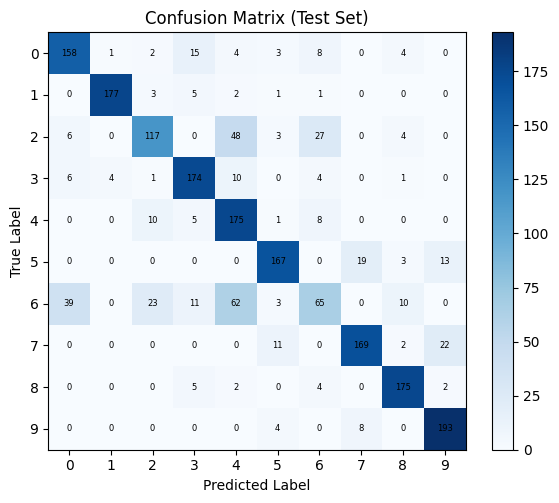

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def confusion_matrix(net, X, true_labels, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(X.shape[1]):
        x_i = X[:, i:i+1]
        _, a_vals = net.forward(x_i)
        pred = int(np.argmax(a_vals[-1]))
        true = int(true_labels[i])
        cm[true, pred] += 1

    return cm


# Compute confusion matrix 
cm = confusion_matrix(net, X_test, y_test, num_classes=10)


# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

# add class numbers along axes
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))

# write numbers into each cell
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=6)

plt.tight_layout()
plt.show()


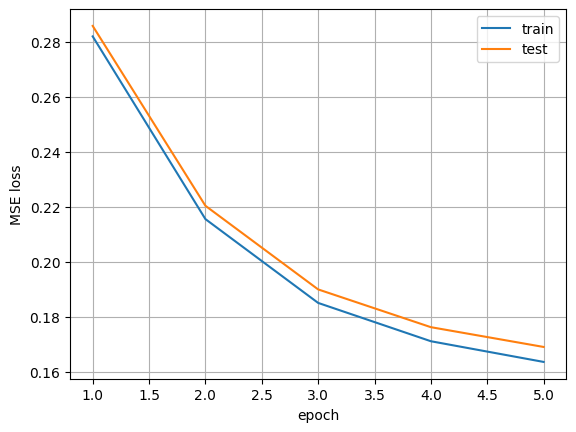

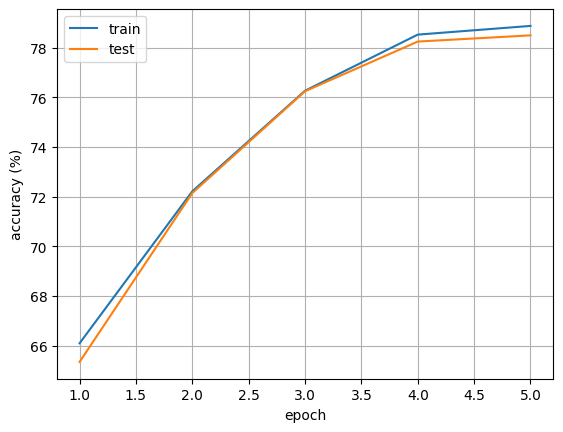

In [ ]:
# Plot loss and accuracy
epochs = np.arange(1, EPOCHS + 1)

plt.figure()
plt.plot(epochs, train_losses, label="train")
plt.plot(epochs, test_losses,  label="test")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, np.array(train_accs)*100, label="train")
plt.plot(epochs, np.array(test_accs)*100,  label="test")
plt.xlabel("epoch")
plt.ylabel("accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Show a few predictions
num_examples = 10
print(f"\nExample predictions (first {num_examples} test samples):")
for i in range(num_examples):
    x_i = X_test[:, i:i+1]
    out = forward_single(net, x_i)
    pred = int(np.argmax(out))
    true = int(y_test[i])
    print(f"sample {i}: true={true}, pred={pred}")



Example predictions (first 10 test samples):
sample 0: true=0, pred=0
sample 1: true=1, pred=1
sample 2: true=2, pred=2
sample 3: true=2, pred=0
sample 4: true=3, pred=4
sample 5: true=2, pred=8
sample 6: true=8, pred=8
sample 7: true=6, pred=6
sample 8: true=5, pred=5
sample 9: true=0, pred=0
